# Clusterization advanced
Dataset z kaggle, zawiera opinie na temat filmów, wraz z ocenami, autorami i innymi podobnymi danymi: https://www.kaggle.com/datasets/subhajournal/movie-rating

## <span style="color:#6042f5"><b>Importy

In [105]:
from collections import Counter

import pandas as pd
from networkx.algorithms.bipartite.basic import color

## <span style="color:#6042f5"><b>Data explo

In [106]:
data = pd.read_csv('./datasets/rotten_movies.csv')
data.where(pd.notnull(data), None)
data.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,audience_count
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0,254287.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0,11567.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0,14670.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0,105000.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0,68860.0


> 📝 <span style="color:lightblue">Komentarz:</span> Istotnie odnośnie danych: w kolumnie critics_consensus mamy 50% brakująych wartości. Rating to jest system wieku. A dopiero te kolumny z tomatometer_rating dają nam jakąś ocenę konkretną. Wszystkie te 'county' odnoszą się do tego ile ocen, brano pod uwagę podczas liczenia oceny. W przypadku ocen tomatometer, brane są pod uwagę opinię krytyków i znanych recenzentów, gdzie w przypadku 'audience_rating' bierzemy oceny każdego użytkownika na temat filmu. Zobaczmy jak wyglądają statystyki dla poszczególnych danych

In [107]:
basic_stat = data.describe()
numeric_labels = basic_stat.columns
basic_stat

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,audience_count
count,16483.000000,16638.000000,16638.000000,16386.000000,1.638600e+04
mean,102.391494,60.466522,56.607104,60.470829,1.524797e+05
std,25.028011,28.587230,66.383800,20.462368,1.817736e+06
min,1.000000,0.000000,5.000000,0.000000,5.000000e+00
25%,90.000000,38.000000,12.000000,45.000000,8.642500e+02
50%,99.000000,66.000000,28.000000,62.000000,4.876500e+03
75%,111.000000,86.000000,76.000000,77.000000,2.875200e+04
max,2000.000000,100.000000,497.000000,100.000000,3.579764e+07


> 📝 <span style="color:lightblue">Komentarz:</span> Jak widać rating, jest od 0 do 100%. Reszta danych wydaję się być mniej istotna w przypadku naszego zadania, którym będzie znalezienie podobnych do siebie filmów. 

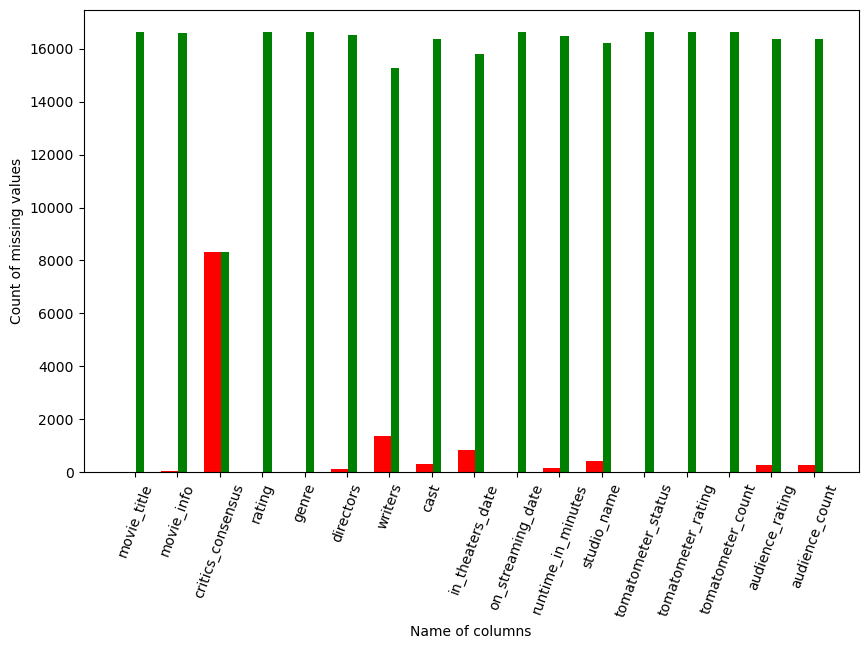

In [108]:
import numpy as np
from matplotlib import pyplot as plt

nulls = []
for col in data.columns:
    cnt = Counter(data[col].notnull())
    nulls.append((col, cnt))

fig, ax = plt.subplots(figsize=(10, 6))
for i,(name,cnt_data) in enumerate(nulls):
    ax.bar(i*4,cnt_data[False], width=2, color='red', label='Null')
    ax.bar((i*4)+1,cnt_data[True], color='green',label='Not null')
    
ax.set_xticks(ticks=np.arange(len(data.columns))*4+0.5,rotation=70,labels=data.columns)
ax.set_xlabel("Name of columns")
ax.set_ylabel("Count of missing values")
plt.show()

> 📝 <span style="color:lightblue">Komentarz:</span> Istotnie niektóre z tych kategori wydają się być niestotne do brania pod uwagę podczas naszego przyrównywania, na przykład oceny użytkowników, albo krytyków, tak naprawdę jeżeli chcemy mieć dobry film podobny tematycznie do siebie to niekoniecznie oceny te też będą do siebie zbliżone. Czas trwania ma znaczenie, chociaż jak zaraz zobaczymy, jest on również różnej długości, tutaj będziemy mieli ten sam problem co w wypadku naszych tweetów vs posty. Zobaczmy rozkład dancyh numerycznych

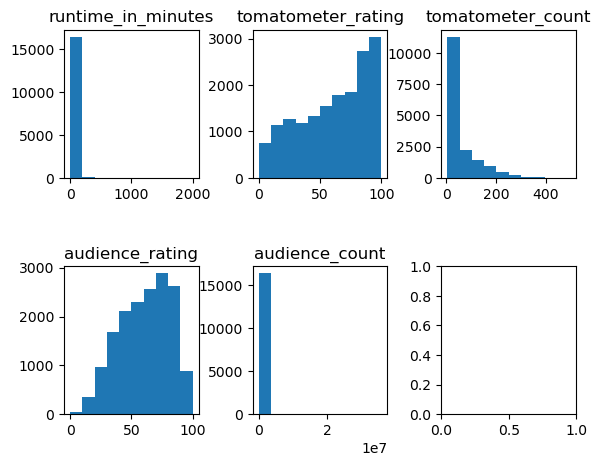

In [119]:
fix,axs = plt.subplots(nrows=2,ncols=3)

for ax,col in zip(axs.flatten(),numeric_labels):
    ax.hist(data[col].values)
    ax.set_title(col)
    
plt.subplots_adjust(
    left=0.1,    # Space from the left edge of the figure
    right=0.9,   # Space from the right edge of the figure
    top=0.9,     # Space from the top edge of the figure
    bottom=0.1,  # Space from the bottom edge of the figure
    wspace=0.4,  # Width space between subplots
    hspace=0.6   # Height space between subplots
)
plt.show()


> 📝 <span style="color:lightblue">Komentarz:</span> Istotnie dużo takich różnych wartości skrajnych, ale zobaczymy, czy będą one przystwarzać problemy

## <span style="color:#6042f5"><b>Analiza danych

### <span style="color:#eb8c34"><b>CountVectorizer